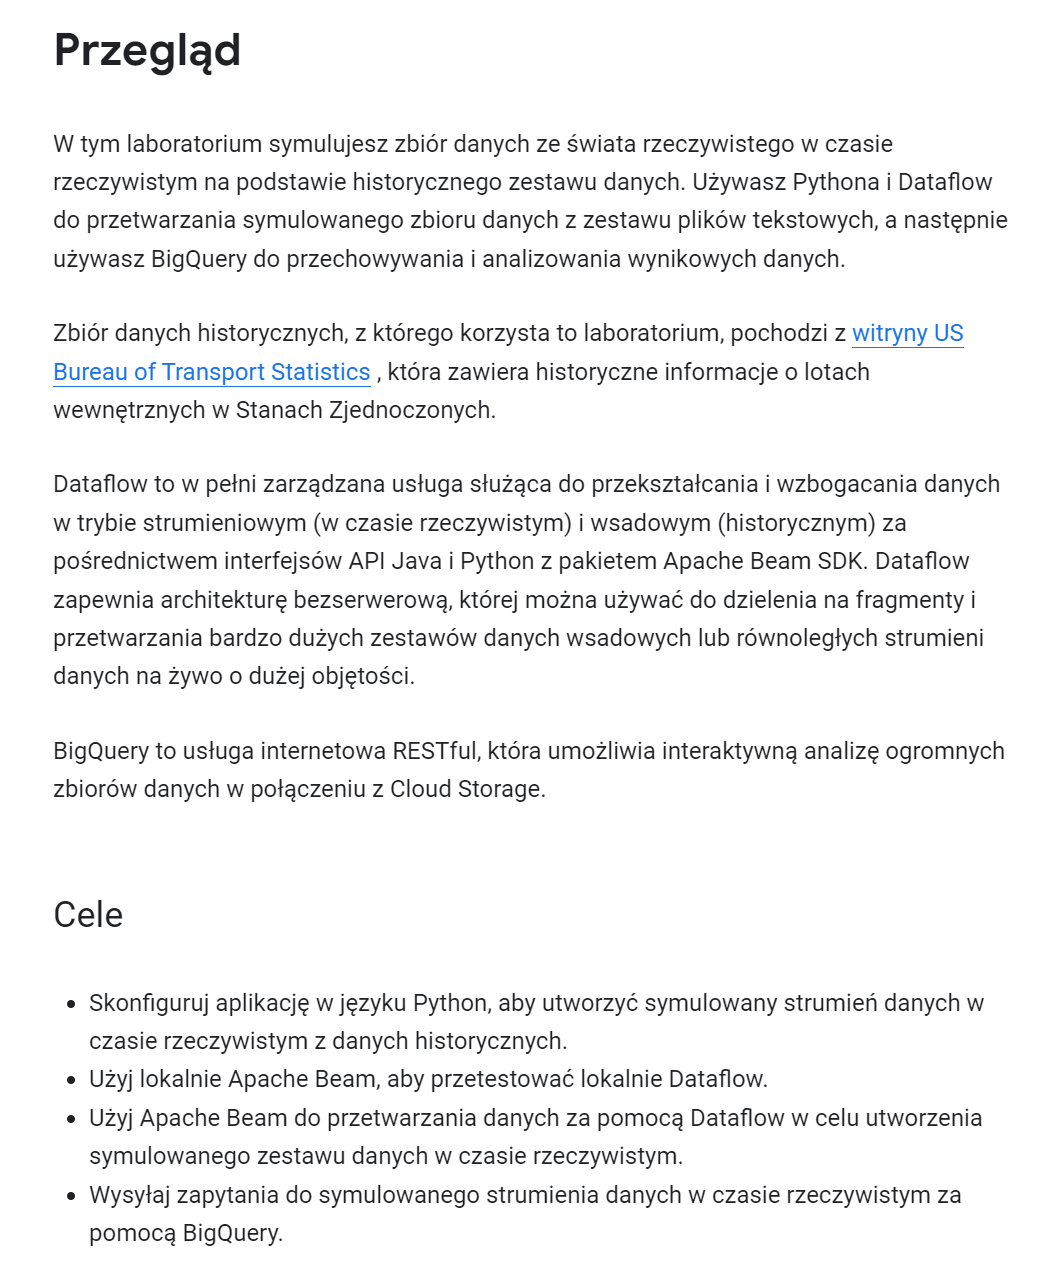

W Lab mam gotowy VM

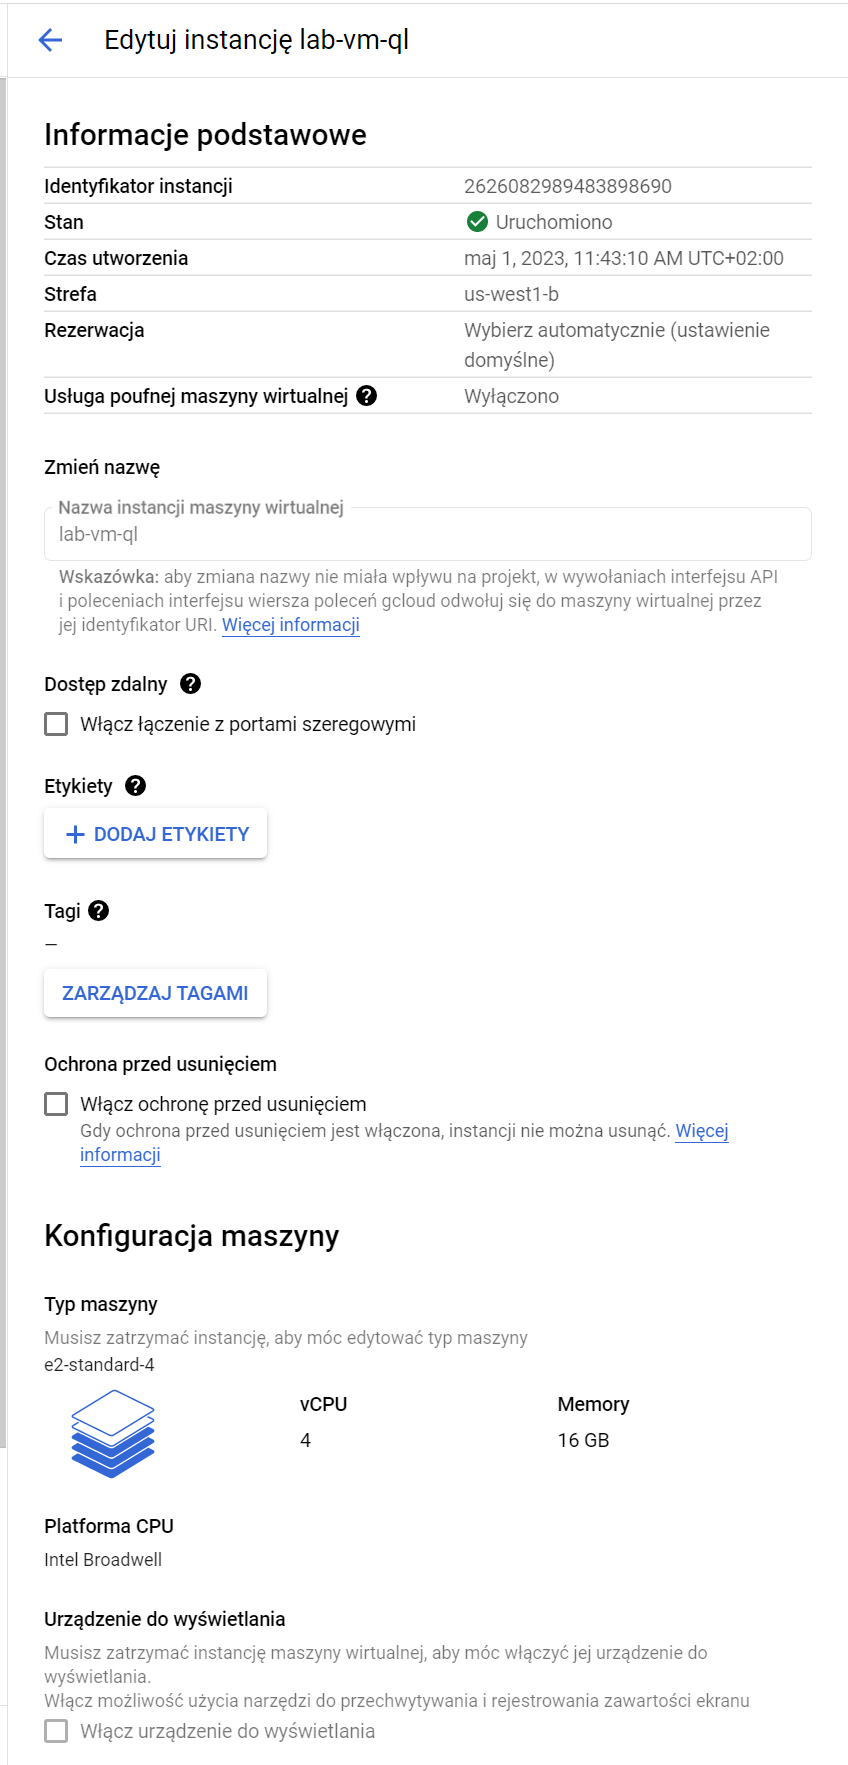

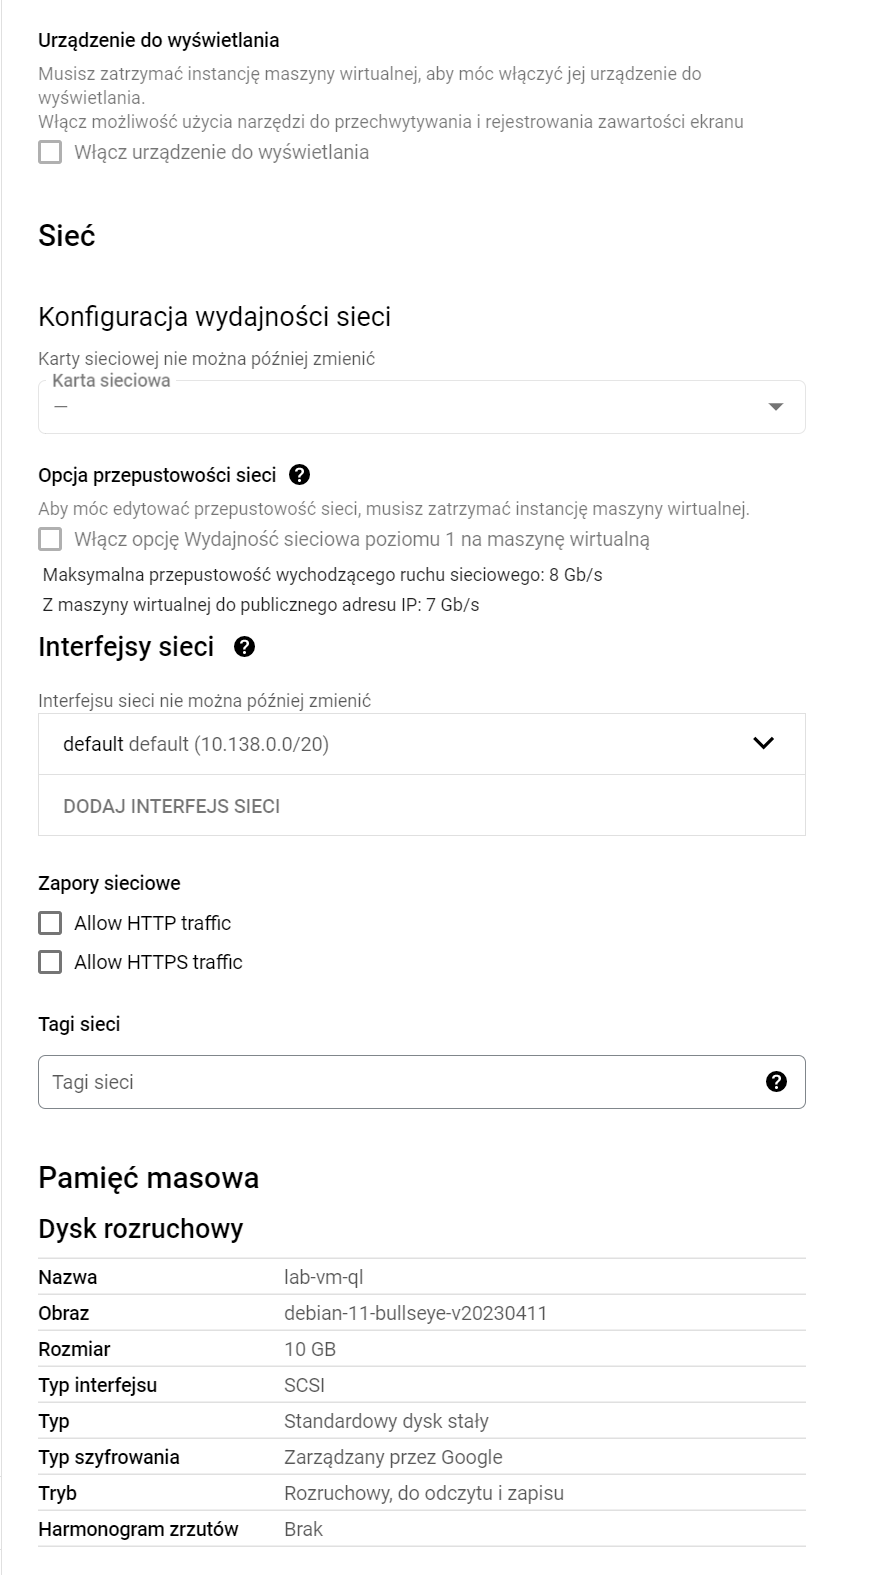

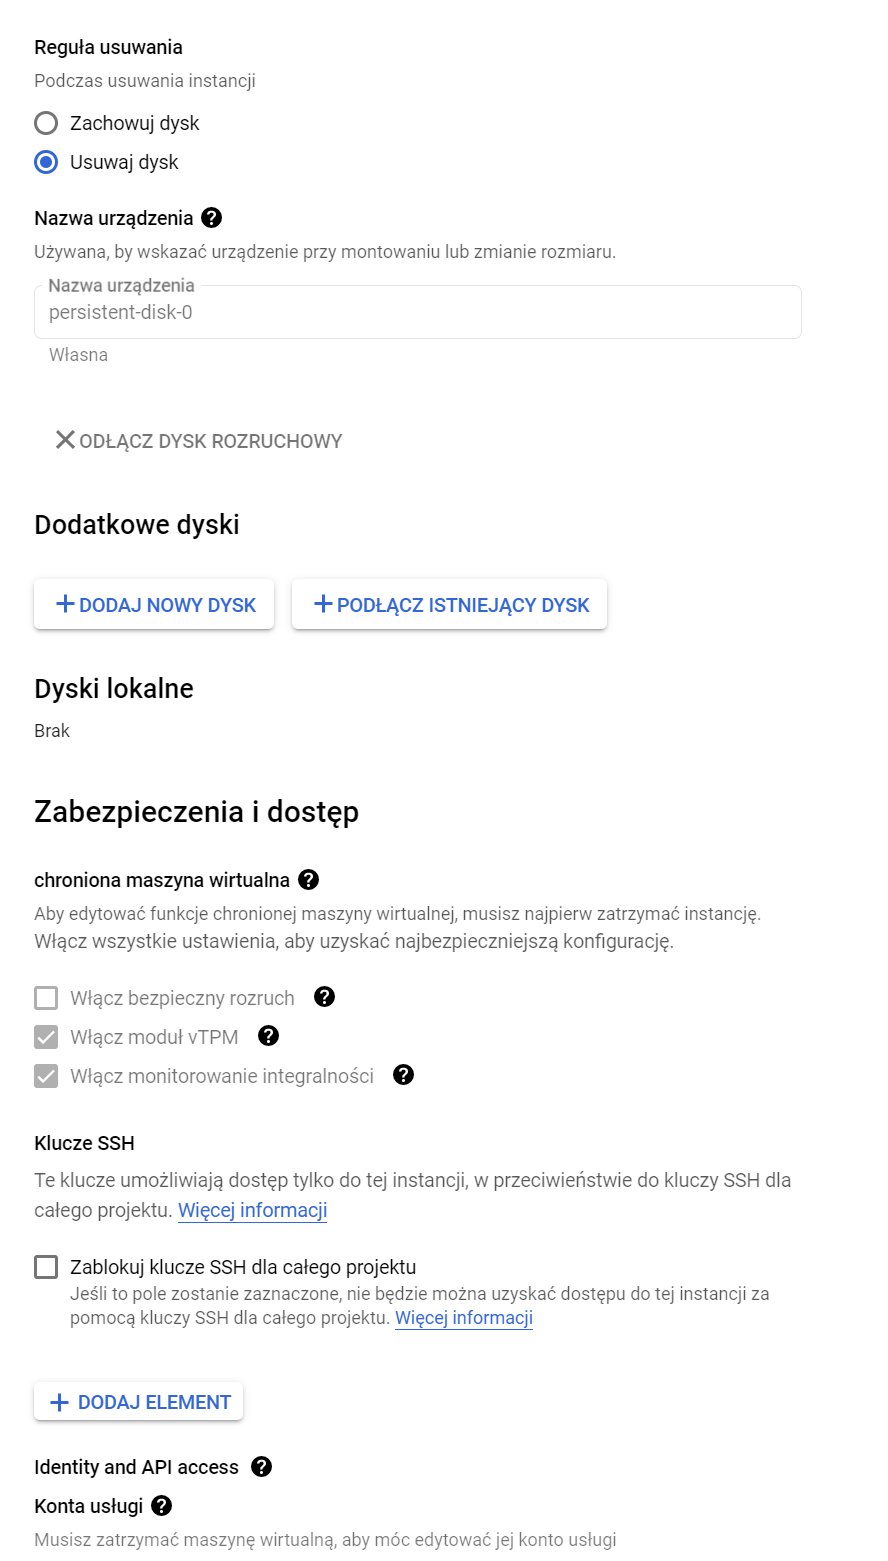

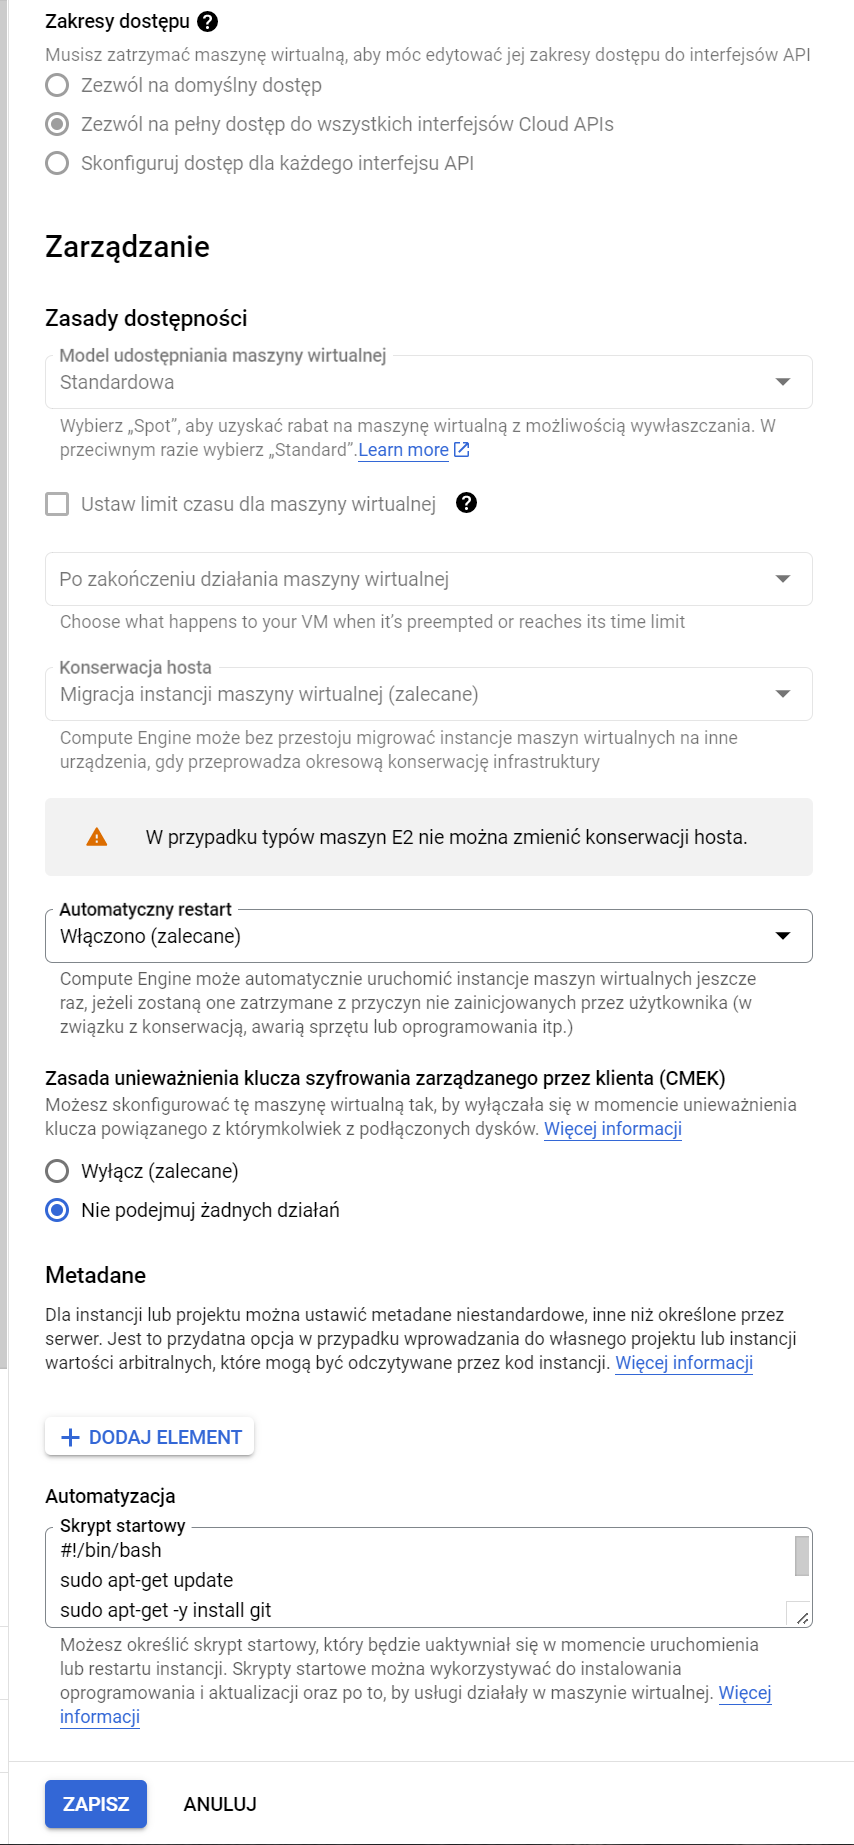

In [ ]:
#!/bin/bash
sudo apt-get update
sudo apt-get -y install git
sudo apt-get -y install python3-pip
git clone https://github.com/GoogleCloudPlatform/data-science-on-gcp
cd data-science-on-gcp
export PROJECT_ID=$(gcloud info --format='value(config.project)')
gsutil mb -l us-west1 gs://$PROJECT_ID-ml
gsutil -m cp gs://data-science-on-gcp/edition2/flights/raw/201501.csv gs://data-science-on-gcp/edition2/flights/raw/201502.csv gs://$PROJECT_ID-ml/flights/raw/

SCHEMA=Year:STRING,Quarter:STRING,Month:STRING,DayofMonth:STRING,DayOfWeek:STRING,FlightDate:DATE,Reporting_Airline:STRING,DOT_ID_Reporting_Airline:STRING,IATA_CODE_Reporting_Airline:STRING,Tail_Number:STRING,Flight_Number_Reporting_Airline:STRING,OriginAirportID:STRING,OriginAirportSeqID:STRING,OriginCityMarketID:STRING,Origin:STRING,OriginCityName:STRING,OriginState:STRING,OriginStateFips:STRING,OriginStateName:STRING,OriginWac:STRING,DestAirportID:STRING,DestAirportSeqID:STRING,DestCityMarketID:STRING,Dest:STRING,DestCityName:STRING,DestState:STRING,DestStateFips:STRING,DestStateName:STRING,DestWac:STRING,CRSDepTime:STRING,DepTime:STRING,DepDelay:STRING,DepDelayMinutes:STRING,DepDel15:STRING,DepartureDelayGroups:STRING,DepTimeBlk:STRING,TaxiOut:STRING,WheelsOff:STRING,WheelsOn:STRING,TaxiIn:STRING,CRSArrTime:STRING,ArrTime:STRING,ArrDelay:STRING,ArrDelayMinutes:STRING,ArrDel15:STRING,ArrivalDelayGroups:STRING,ArrTimeBlk:STRING,Cancelled:STRING,CancellationCode:STRING,Diverted:STRING,CRSElapsedTime:STRING,ActualElapsedTime:STRING,AirTime:STRING,Flights:STRING,Distance:STRING,DistanceGroup:STRING,CarrierDelay:STRING,WeatherDelay:STRING,NASDelay:STRING,SecurityDelay:STRING,LateAircraftDelay:STRING,FirstDepTime:STRING,TotalAddGTime:STRING,LongestAddGTime:STRING,DivAirportLandings:STRING,DivReachedDest:STRING,DivActualElapsedTime:STRING,DivArrDelay:STRING,DivDistance:STRING,Div1Airport:STRING,Div1AirportID:STRING,Div1AirportSeqID:STRING,Div1WheelsOn:STRING,Div1TotalGTime:STRING,Div1LongestGTime:STRING,Div1WheelsOff:STRING,Div1TailNum:STRING,Div2Airport:STRING,Div2AirportID:STRING,Div2AirportSeqID:STRING,Div2WheelsOn:STRING,Div2TotalGTime:STRING,Div2LongestGTime:STRING,Div2WheelsOff:STRING,Div2TailNum:STRING,Div3Airport:STRING,Div3AirportID:STRING,Div3AirportSeqID:STRING,Div3WheelsOn:STRING,Div3TotalGTime:STRING,Div3LongestGTime:STRING,Div3WheelsOff:STRING,Div3TailNum:STRING,Div4Airport:STRING,Div4AirportID:STRING,Div4AirportSeqID:STRING,Div4WheelsOn:STRING,Div4TotalGTime:STRING,Div4LongestGTime:STRING,Div4WheelsOff:STRING,Div4TailNum:STRING,Div5Airport:STRING,Div5AirportID:STRING,Div5AirportSeqID:STRING,Div5WheelsOn:STRING,Div5TotalGTime:STRING,Div5LongestGTime:STRING,Div5WheelsOff:STRING,Div5TailNum:STRING

bq --project_id $PROJECT_ID show dsongcp || bq mk --sync dsongcp
for MONTH in `seq -w 1 2`; do

CSVFILE=gs://$PROJECT_ID-ml/flights/raw/20150$MONTH.csv
bq --project_id $PROJECT_ID  --sync \
load --time_partitioning_field=FlightDate --time_partitioning_type=MONTH \
--source_format=CSV --ignore_unknown_values --skip_leading_rows=1 --schema=$SCHEMA \
--replace $PROJECT_ID:dsongcp.flights_raw\$20150$MONTH $CSVFILE

done
cd 03_sqlstudio
./create_views.sh
gcloud services disable dataflow.googleapis.com
gcloud services enable dataflow.googleapis.com
#gcloud compute instances delete lab-vm-ql --zone us-west1-b --quiet


In [ ]:
# https://github.com/GoogleCloudPlatform/data-science-on-gcp

##Zadanie 1. Przygotuj swoje środowisko

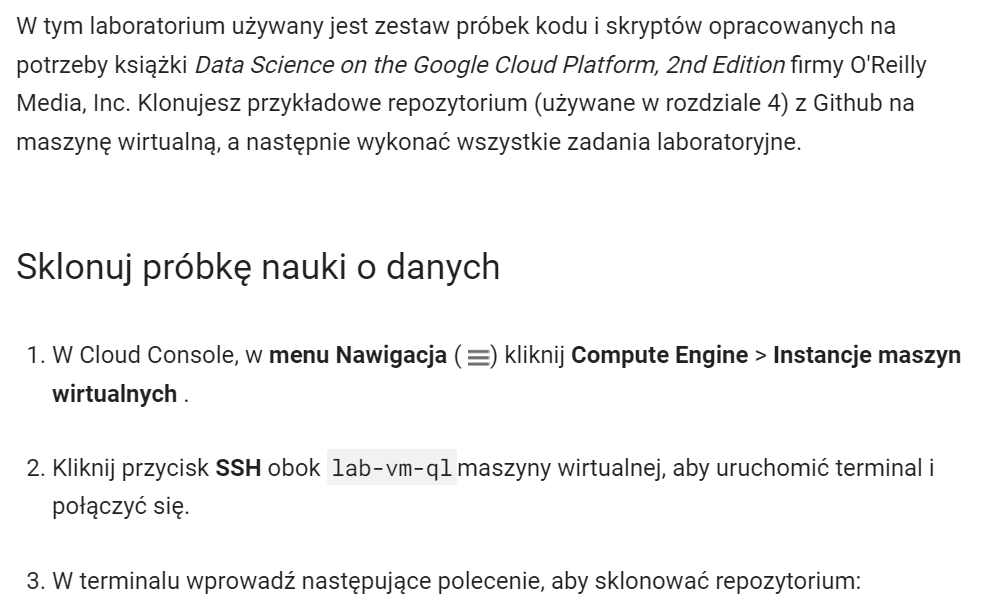

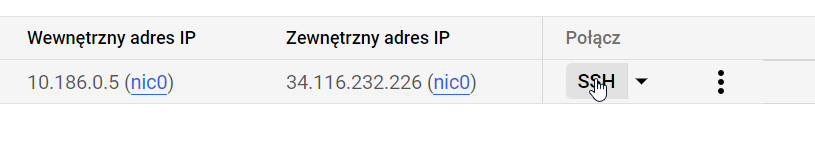

In [ ]:
git clone https://github.com/GoogleCloudPlatform/data-science-on-gcp/

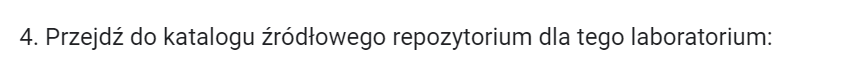

In [ ]:
cd ~/data-science-on-gcp/04_streaming/transform

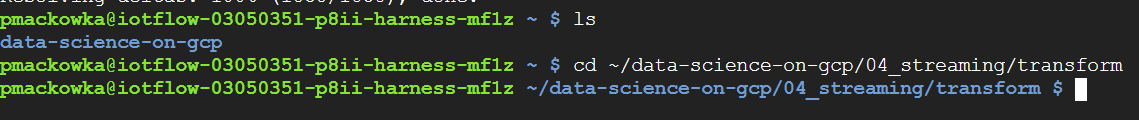

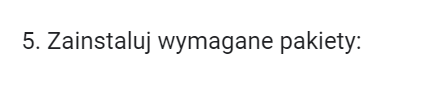

In [ ]:
./install_packages.sh

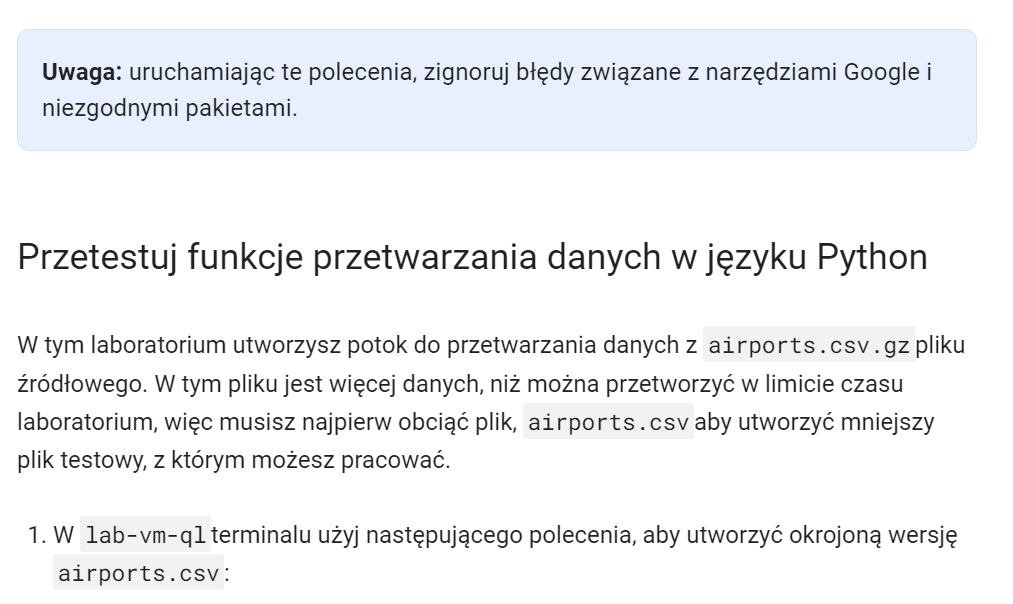

In [ ]:
gzip -d airports.csv.gz
head -n1000 airports.csv > temp.csv
mv airports.csv airports.csv.backup
mv temp.csv  airports.csv
gzip airports.csv

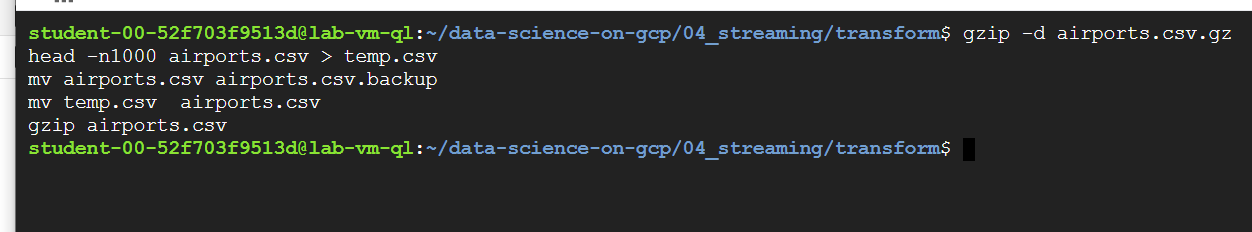

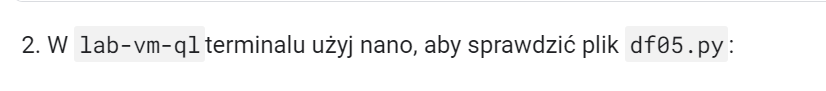

In [ ]:
nano df05.py

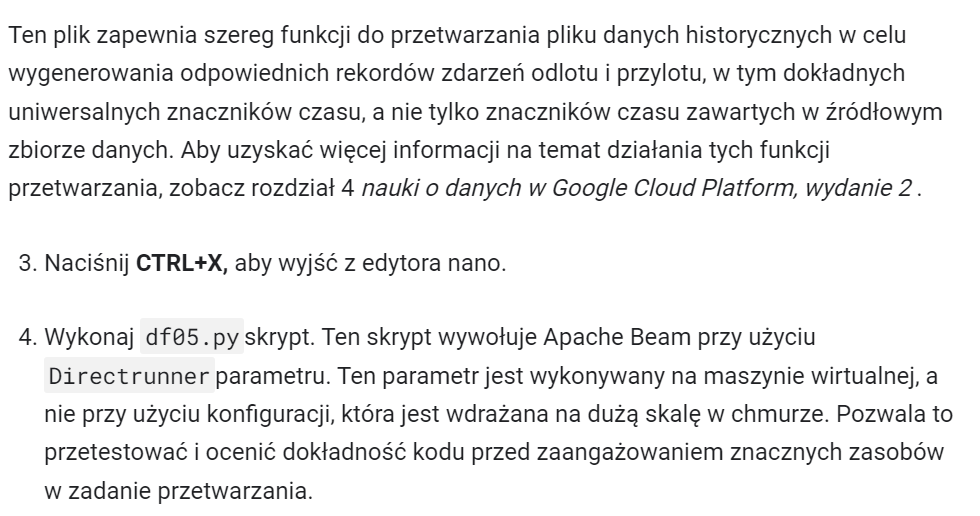

###`df05.py`

In [ ]:
# https://github.com/GoogleCloudPlatform/data-science-on-gcp/blob/main/04_streaming/transform/df05.py

#!/usr/bin/env python3

# Copyright 2016 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import apache_beam as beam
import logging
import csv
import json

DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'


def addtimezone(lat, lon):
    try:
        import timezonefinder
        tf = timezonefinder.TimezoneFinder()
        lat = float(lat)
        lon = float(lon)
        return lat, lon, tf.timezone_at(lng=lon, lat=lat)
    except ValueError:
        return lat, lon, 'TIMEZONE'  # header


def as_utc(date, hhmm, tzone):
    """
   Returns date corrected for timezone, and the tzoffset
   """
    try:
        if len(hhmm) > 0 and tzone is not None:
            import datetime, pytz
            loc_tz = pytz.timezone(tzone)
            loc_dt = loc_tz.localize(datetime.datetime.strptime(date, '%Y-%m-%d'), is_dst=False)
            # can't just parse hhmm because the data contains 2400 and the like ...
            loc_dt += datetime.timedelta(hours=int(hhmm[:2]), minutes=int(hhmm[2:]))
            utc_dt = loc_dt.astimezone(pytz.utc)
            return utc_dt.strftime(DATETIME_FORMAT), loc_dt.utcoffset().total_seconds()
        else:
            return '', 0  # empty string corresponds to canceled flights
    except ValueError as e:
        logging.exception('{} {} {}'.format(date, hhmm, tzone))
        raise e


def add_24h_if_before(arrtime, deptime):
    import datetime
    if len(arrtime) > 0 and len(deptime) > 0 and arrtime < deptime:
        adt = datetime.datetime.strptime(arrtime, DATETIME_FORMAT)
        adt += datetime.timedelta(hours=24)
        return adt.strftime(DATETIME_FORMAT)
    else:
        return arrtime


def tz_correct(fields, airport_timezones):
    try:
        # convert all times to UTC
        dep_airport_id = fields["ORIGIN_AIRPORT_SEQ_ID"]
        arr_airport_id = fields["DEST_AIRPORT_SEQ_ID"]
        dep_timezone = airport_timezones[dep_airport_id][2]
        arr_timezone = airport_timezones[arr_airport_id][2]

        for f in ["CRS_DEP_TIME", "DEP_TIME", "WHEELS_OFF"]:
            fields[f], deptz = as_utc(fields["FL_DATE"], fields[f], dep_timezone)
        for f in ["WHEELS_ON", "CRS_ARR_TIME", "ARR_TIME"]:
            fields[f], arrtz = as_utc(fields["FL_DATE"], fields[f], arr_timezone)

        for f in ["WHEELS_OFF", "WHEELS_ON", "CRS_ARR_TIME", "ARR_TIME"]:
            fields[f] = add_24h_if_before(fields[f], fields["DEP_TIME"])

        fields["DEP_AIRPORT_LAT"] = airport_timezones[dep_airport_id][0]
        fields["DEP_AIRPORT_LON"] = airport_timezones[dep_airport_id][1]
        fields["DEP_AIRPORT_TZOFFSET"] = deptz
        fields["ARR_AIRPORT_LAT"] = airport_timezones[arr_airport_id][0]
        fields["ARR_AIRPORT_LON"] = airport_timezones[arr_airport_id][1]
        fields["ARR_AIRPORT_TZOFFSET"] = arrtz
        yield fields
    except KeyError as e:
        logging.exception(f"Ignoring {fields} because airport is not known")


def get_next_event(fields):
    if len(fields["DEP_TIME"]) > 0:
        event = dict(fields)  # copy
        event["EVENT_TYPE"] = "departed"
        event["EVENT_TIME"] = fields["DEP_TIME"]
        for f in ["TAXI_OUT", "WHEELS_OFF", "WHEELS_ON", "TAXI_IN", "ARR_TIME", "ARR_DELAY", "DISTANCE"]:
            event.pop(f, None)  # not knowable at departure time
        yield event
    if len(fields["ARR_TIME"]) > 0:
        event = dict(fields)
        event["EVENT_TYPE"] = "arrived"
        event["EVENT_TIME"] = fields["ARR_TIME"]
        yield event


def run():
    with beam.Pipeline('DirectRunner') as pipeline:
        airports = (pipeline
                    | 'airports:read' >> beam.io.ReadFromText('airports.csv.gz')
                    | beam.Filter(lambda line: "United States" in line)
                    | 'airports:fields' >> beam.Map(lambda line: next(csv.reader([line])))
                    | 'airports:tz' >> beam.Map(lambda fields: (fields[0], addtimezone(fields[21], fields[26])))
                    )

        flights = (pipeline
                   | 'flights:read' >> beam.io.ReadFromText('flights_sample.json')
                   | 'flights:parse' >> beam.Map(lambda line: json.loads(line))
                   | 'flights:tzcorr' >> beam.FlatMap(tz_correct, beam.pvalue.AsDict(airports))
                   )

        (flights
         | 'flights:tostring' >> beam.Map(lambda fields: json.dumps(fields))
         | 'flights:out' >> beam.io.textio.WriteToText('all_flights')
         )

        events = flights | beam.FlatMap(get_next_event)

        (events
         | 'events:tostring' >> beam.Map(lambda fields: json.dumps(fields))
         | 'events:out' >> beam.io.textio.WriteToText('all_events')
         )


if __name__ == '__main__':
    run()

In [ ]:
def run():
  with bean.Pipeline('DirectRunner') as pipeline:

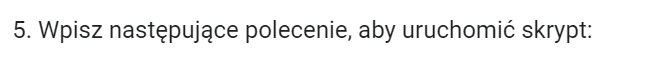

In [ ]:
./df05.py

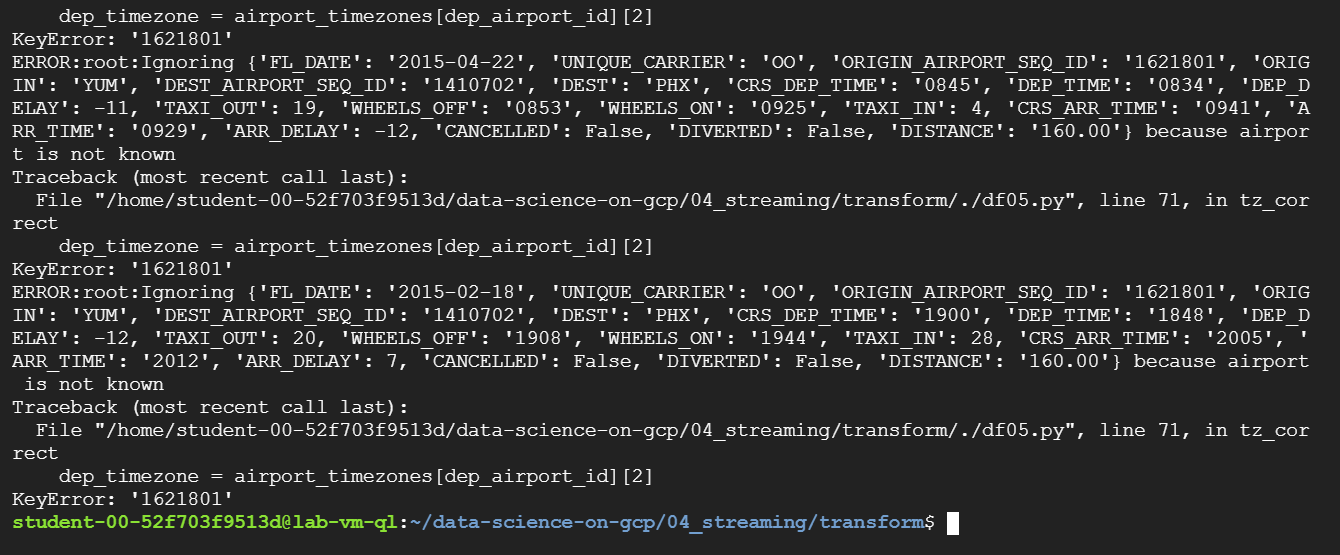

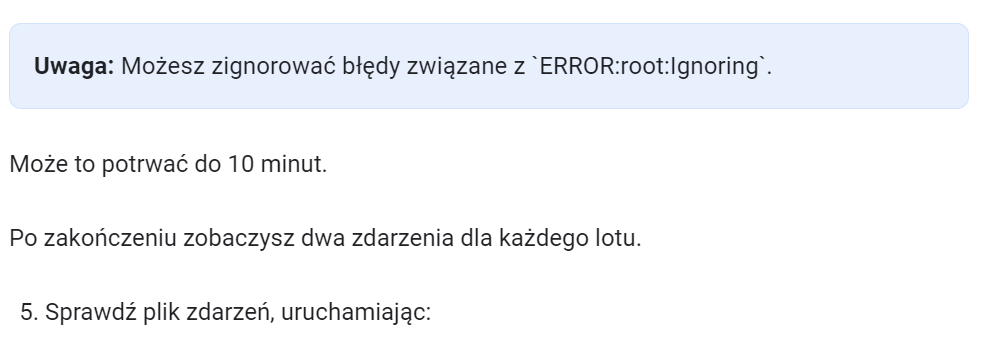

In [ ]:
head -3 all_events-00000*

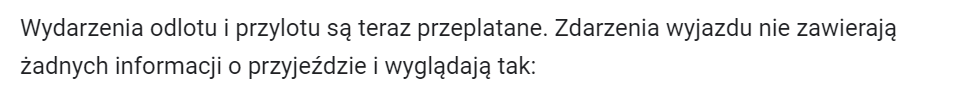

In [ ]:
student-00-52f703f9513d@lab-vm-ql:~/data-science-on-gcp/04_streaming/transform$ head -3 all_events-00000*
{"FL_DATE": "2015-04-28", "UNIQUE_CARRIER": "EV", "ORIGIN_AIRPORT_SEQ_ID": "1013503", "ORIGIN": "ABE", "DEST_AIRPORT_SEQ_ID": "1039705", "DEST": "ATL", "CRS_DEP_TIME": "2015-04-28 20:00:00", "DEP_TIME": "2015-04-28 19:55:00", "DEP_DELAY": -5, "CRS_ARR_TIME": "2015-04-28 22:09:00", "CANCELLED": false, "DIVERTED": false, "DEP_AIRPORT_LAT": 40.65222222, "DEP_AIRPORT_LON": -75.44055556, "DEP_AIRPORT_TZOFFSET": -14400.0, "ARR_AIRPORT_LAT": 33.63666667, "ARR_AIRPORT_LON": -84.42777778, "ARR_AIRPORT_TZOFFSET": -14400.0, "EVENT_TYPE": "departed", "EVENT_TIME": "2015-04-28 19:55:00"}
{"FL_DATE": "2015-04-28", "UNIQUE_CARRIER": "EV", "ORIGIN_AIRPORT_SEQ_ID": "1013503", "ORIGIN": "ABE", "DEST_AIRPORT_SEQ_ID": "1039705", "DEST": "ATL", "CRS_DEP_TIME": "2015-04-28 20:00:00", "DEP_TIME": "2015-04-28 19:55:00", "DEP_DELAY": -5, "TAXI_OUT": 7, "WHEELS_OFF": "2015-04-28 20:02:00", "WHEELS_ON": "2015-04-28 21:47:00", "TAXI_IN": 4, "CRS_ARR_TIME": "2015-04-28 22:09:00", "ARR_TIME": "2015-04-28 21:51:00", "ARR_DELAY": -18, "CANCELLED": false, "DIVERTED": false, "DISTANCE": "692.00", "DEP_AIRPORT_LAT": 40.65222222, "DEP_AIRPORT_LON": -75.44055556, "DEP_AIRPORT_TZOFFSET": -14400.0, "ARR_AIRPORT_LAT": 33.63666667, "ARR_AIRPORT_LON": -84.42777778, "ARR_AIRPORT_TZOFFSET": -14400.0, "EVENT_TYPE": "arrived", "EVENT_TIME": "2015-04-28 21:51:00"}
{"FL_DATE": "2015-11-05", "UNIQUE_CARRIER": "DL", "ORIGIN_AIRPORT_SEQ_ID": "1013503", "ORIGIN": "ABE", "DEST_AIRPORT_SEQ_ID": "1039705", "DEST": "ATL", "CRS_DEP_TIME": "2015-11-05 11:00:00", "DEP_TIME": "2015-11-05 10:56:00", "DEP_DELAY": -4, "CRS_ARR_TIME": "2015-11-05 13:18:00", "CANCELLED": false, "DIVERTED": false, "DEP_AIRPORT_LAT": 40.65222222, "DEP_AIRPORT_LON": -75.44055556, "DEP_AIRPORT_TZOFFSET": -18000.0, "ARR_AIRPORT_LAT": 33.63666667, "ARR_AIRPORT_LON": -84.42777778, "ARR_AIRPORT_TZOFFSET": -18000.0, "EVENT_TYPE": "departed", "EVENT_TIME": "2015-11-05 10:56:00"}
student-00-52f703f9513d@lab-vm-ql:~/data-science-on-gcp/04_streaming/transform$

In [ ]:
# "EVENT_TYPE": "departed"

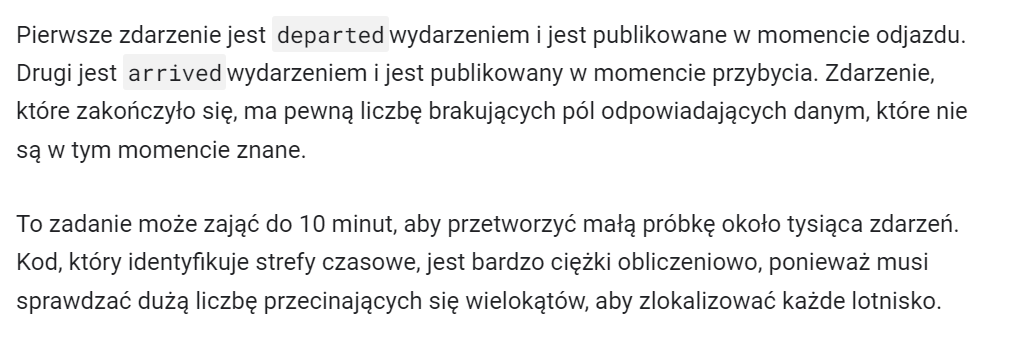

##Zadanie 2. Odczyt i zapis w chmurze

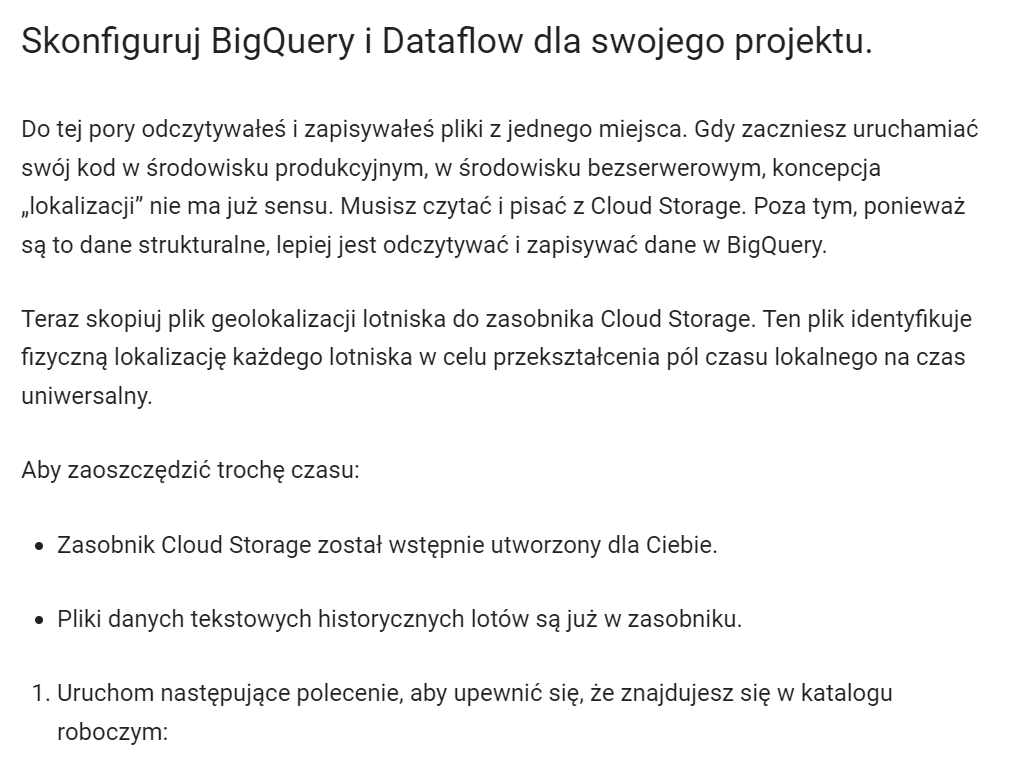

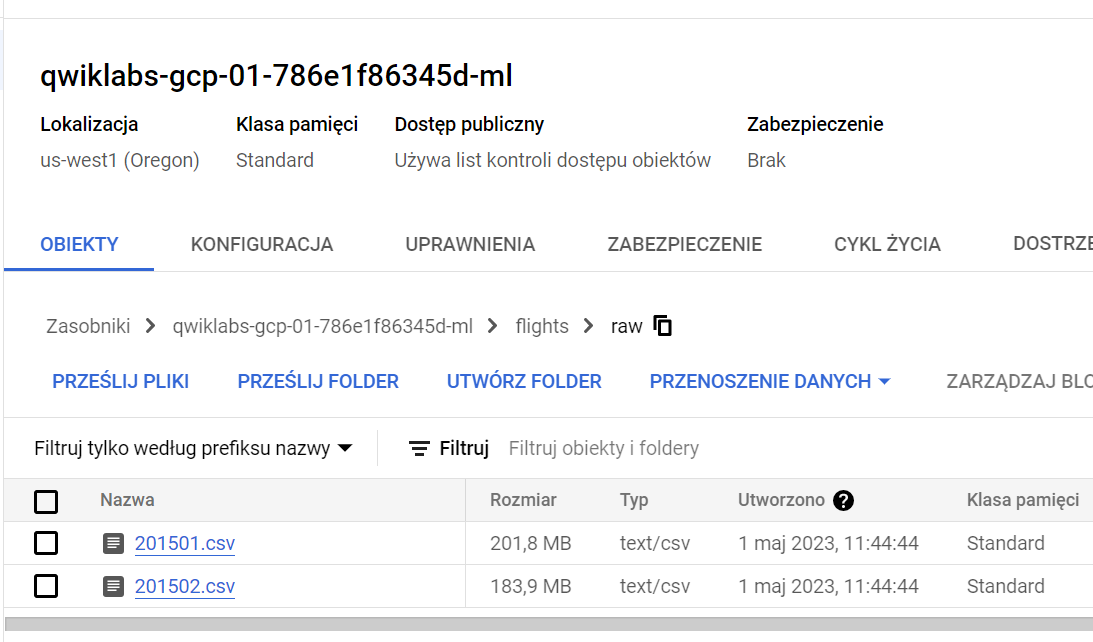

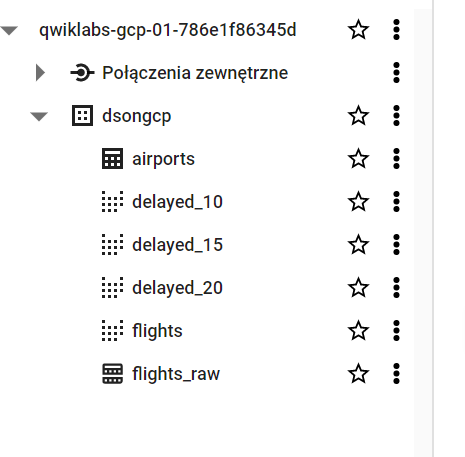

In [ ]:
cd ~/data-science-on-gcp/04_streaming/transform

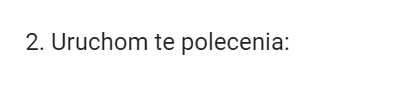

####`df06.py`

In [ ]:
#!/usr/bin/env python3

# Copyright 2016 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import apache_beam as beam
import logging
import csv
import json


DATETIME_FORMAT = '%Y-%m-%dT%H:%M:%S'


def addtimezone(lat, lon):
    try:
        import timezonefinder
        tf = timezonefinder.TimezoneFinder()
        lat = float(lat)
        lon = float(lon)
        return lat, lon, tf.timezone_at(lng=lon, lat=lat)
    except ValueError:
        return lat, lon, 'TIMEZONE'  # header


def as_utc(date, hhmm, tzone):
    """
    Returns date corrected for timezone, and the tzoffset
    """
    try:
        if len(hhmm) > 0 and tzone is not None:
            import datetime, pytz
            loc_tz = pytz.timezone(tzone)
            loc_dt = loc_tz.localize(datetime.datetime.strptime(date, '%Y-%m-%d'), is_dst=False)
            # can't just parse hhmm because the data contains 2400 and the like ...
            loc_dt += datetime.timedelta(hours=int(hhmm[:2]), minutes=int(hhmm[2:]))
            utc_dt = loc_dt.astimezone(pytz.utc)
            return utc_dt.strftime(DATETIME_FORMAT), loc_dt.utcoffset().total_seconds()
        else:
            return '', 0  # empty string corresponds to canceled flights
    except ValueError as e:
        logging.exception('{} {} {}'.format(date, hhmm, tzone))
        raise e


def add_24h_if_before(arrtime, deptime):
    import datetime
    if len(arrtime) > 0 and len(deptime) > 0 and arrtime < deptime:
        adt = datetime.datetime.strptime(arrtime, DATETIME_FORMAT)
        adt += datetime.timedelta(hours=24)
        return adt.strftime(DATETIME_FORMAT)
    else:
        return arrtime


def tz_correct(fields, airport_timezones):
    fields['FL_DATE'] = fields['FL_DATE'].strftime('%Y-%m-%d')  # convert to a string so JSON code works
    try:
        # convert all times to UTC
        dep_airport_id = fields["ORIGIN_AIRPORT_SEQ_ID"]
        arr_airport_id = fields["DEST_AIRPORT_SEQ_ID"]

        dep_timezone = airport_timezones[dep_airport_id][2]
        arr_timezone = airport_timezones[arr_airport_id][2]

        for f in ["CRS_DEP_TIME", "DEP_TIME", "WHEELS_OFF"]:
            fields[f], deptz = as_utc(fields["FL_DATE"], fields[f], dep_timezone)
        for f in ["WHEELS_ON", "CRS_ARR_TIME", "ARR_TIME"]:
            fields[f], arrtz = as_utc(fields["FL_DATE"], fields[f], arr_timezone)

        for f in ["WHEELS_OFF", "WHEELS_ON", "CRS_ARR_TIME", "ARR_TIME"]:
            fields[f] = add_24h_if_before(fields[f], fields["DEP_TIME"])

        fields["DEP_AIRPORT_LAT"] = airport_timezones[dep_airport_id][0]
        fields["DEP_AIRPORT_LON"] = airport_timezones[dep_airport_id][1]
        fields["DEP_AIRPORT_TZOFFSET"] = deptz
        fields["ARR_AIRPORT_LAT"] = airport_timezones[arr_airport_id][0]
        fields["ARR_AIRPORT_LON"] = airport_timezones[arr_airport_id][1]
        fields["ARR_AIRPORT_TZOFFSET"] = arrtz
        yield fields
    except KeyError:
        #logging.exception(f"Ignoring {fields} because airport is not known")
        pass

    except KeyError:
        logging.exception("Ignoring field because airport is not known")


def get_next_event(fields):
    if len(fields["DEP_TIME"]) > 0:
        event = dict(fields)  # copy
        event["EVENT_TYPE"] = "departed"
        event["EVENT_TIME"] = fields["DEP_TIME"]
        for f in ["TAXI_OUT", "WHEELS_OFF", "WHEELS_ON", "TAXI_IN", "ARR_TIME", "ARR_DELAY", "DISTANCE"]:
            event.pop(f, None)  # not knowable at departure time
        yield event
    if len(fields["WHEELS_OFF"]) > 0:
        event = dict(fields)  # copy
        event["EVENT_TYPE"] = "wheelsoff"
        event["EVENT_TIME"] = fields["WHEELS_OFF"]
        for f in ["WHEELS_ON", "TAXI_IN", "ARR_TIME", "ARR_DELAY", "DISTANCE"]:
            event.pop(f, None)  # not knowable at departure time
        yield event
    if len(fields["ARR_TIME"]) > 0:
        event = dict(fields)
        event["EVENT_TYPE"] = "arrived"
        event["EVENT_TIME"] = fields["ARR_TIME"]
        yield event


def create_event_row(fields):
    featdict = dict(fields)  # copy
    featdict['EVENT_DATA'] = json.dumps(fields)
    return featdict


def run(project, bucket):
    argv = [
        '--project={0}'.format(project),
        '--staging_location=gs://{0}/flights/staging/'.format(bucket),
        '--temp_location=gs://{0}/flights/temp/'.format(bucket),
        '--runner=DirectRunner'
    ]
    airports_filename = 'gs://{}/flights/airports/airports.csv.gz'.format(bucket)
    flights_output = 'gs://{}/flights/tzcorr/all_flights'.format(bucket)

    with beam.Pipeline(argv=argv) as pipeline:
        airports = (pipeline
                    | 'airports:read' >> beam.io.ReadFromText(airports_filename)
                    | beam.Filter(lambda line: "United States" in line)
                    | 'airports:fields' >> beam.Map(lambda line: next(csv.reader([line])))
                    | 'airports:tz' >> beam.Map(lambda fields: (fields[0], addtimezone(fields[21], fields[26])))
                    )

        flights = (pipeline
                   | 'flights:read' >> beam.io.ReadFromBigQuery(
                    query='SELECT * FROM dsongcp.flights WHERE rand() < 0.001', use_standard_sql=True)
                   | 'flights:tzcorr' >> beam.FlatMap(tz_correct, beam.pvalue.AsDict(airports))
                   )

        (flights
         | 'flights:tostring' >> beam.Map(lambda fields: json.dumps(fields))
         | 'flights:gcsout' >> beam.io.textio.WriteToText(flights_output)
         )

        flights_schema = ','.join([
            'FL_DATE:date',
            'UNIQUE_CARRIER:string',
            'ORIGIN_AIRPORT_SEQ_ID:string',
            'ORIGIN:string',
            'DEST_AIRPORT_SEQ_ID:string',
            'DEST:string',
            'CRS_DEP_TIME:timestamp',
            'DEP_TIME:timestamp',
            'DEP_DELAY:float',
            'TAXI_OUT:float',
            'WHEELS_OFF:timestamp',
            'WHEELS_ON:timestamp',
            'TAXI_IN:float',
            'CRS_ARR_TIME:timestamp',
            'ARR_TIME:timestamp',
            'ARR_DELAY:float',
            'CANCELLED:boolean',
            'DIVERTED:boolean',
            'DISTANCE:float',
            'DEP_AIRPORT_LAT:float',
            'DEP_AIRPORT_LON:float',
            'DEP_AIRPORT_TZOFFSET:float',
            'ARR_AIRPORT_LAT:float',
            'ARR_AIRPORT_LON:float',
            'ARR_AIRPORT_TZOFFSET:float',
            'Year:string'])

        # autodetect on JSON works, but is less reliable
        #flights_schema = 'SCHEMA_AUTODETECT'

        (flights
         | 'flights:bqout' >> beam.io.WriteToBigQuery(
                'dsongcp.flights_tzcorr',
                schema=flights_schema,
                write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE,
                create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED
                )
        )

        events = flights | beam.FlatMap(get_next_event)
        events_schema = ','.join([flights_schema, 'EVENT_TYPE:string,EVENT_TIME:timestamp,EVENT_DATA:string'])

        (events
         | 'events:totablerow' >> beam.Map(lambda fields: create_event_row(fields))
         | 'events:bqout' >> beam.io.WriteToBigQuery(
                'dsongcp.flights_simevents', schema=events_schema,
                write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE,
                create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED
                )
        )

if __name__ == '__main__':
    import argparse

    parser = argparse.ArgumentParser(description='Run pipeline on the cloud')
    parser.add_argument('-p', '--project', help='Unique project ID', required=True)
    parser.add_argument('-b', '--bucket', help='Bucket where gs://BUCKET/flights/airports/airports.csv.gz exists',
                        required=True)

    args = vars(parser.parse_args())

    print("Correcting timestamps and writing to BigQuery dataset")

    run(project=args['project'], bucket=args['bucket'])

In [ ]:
export PROJECT_ID=$(gcloud info --format='value(config.project)')
export BUCKET=${PROJECT_ID}-ml
./stage_airports_file.sh $BUCKET
./df06.py --project $PROJECT_ID --bucket $BUCKET

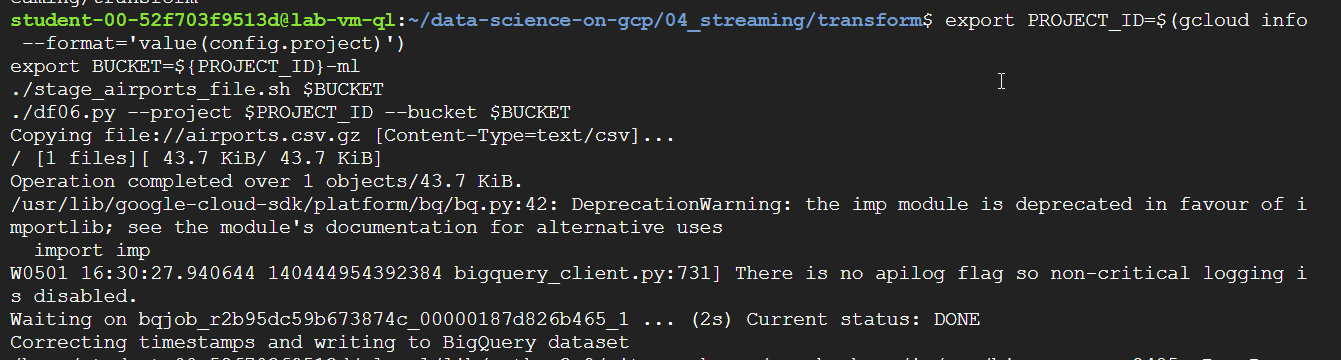

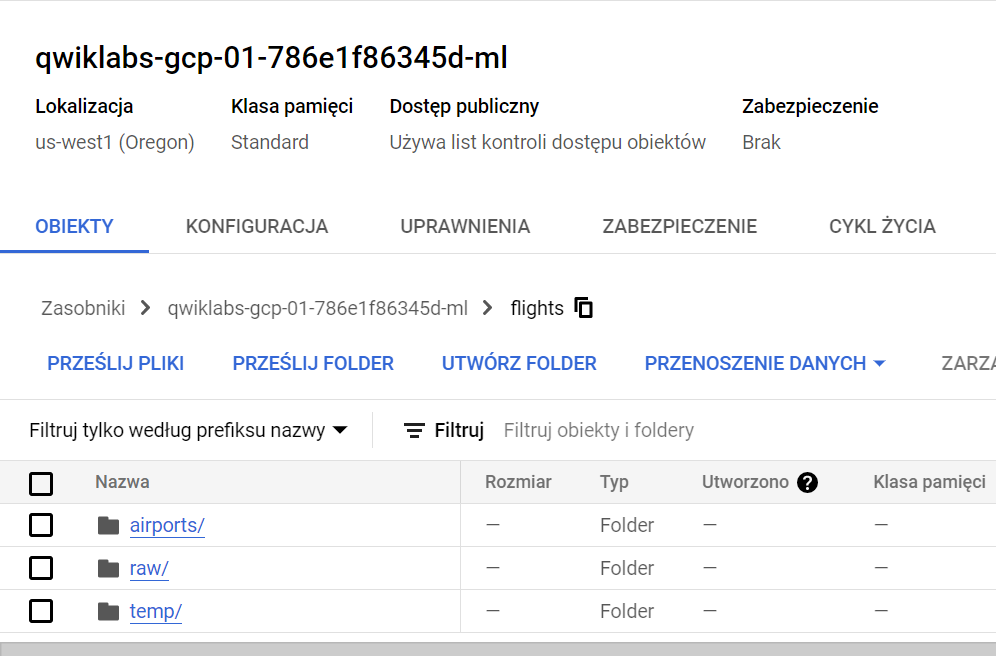

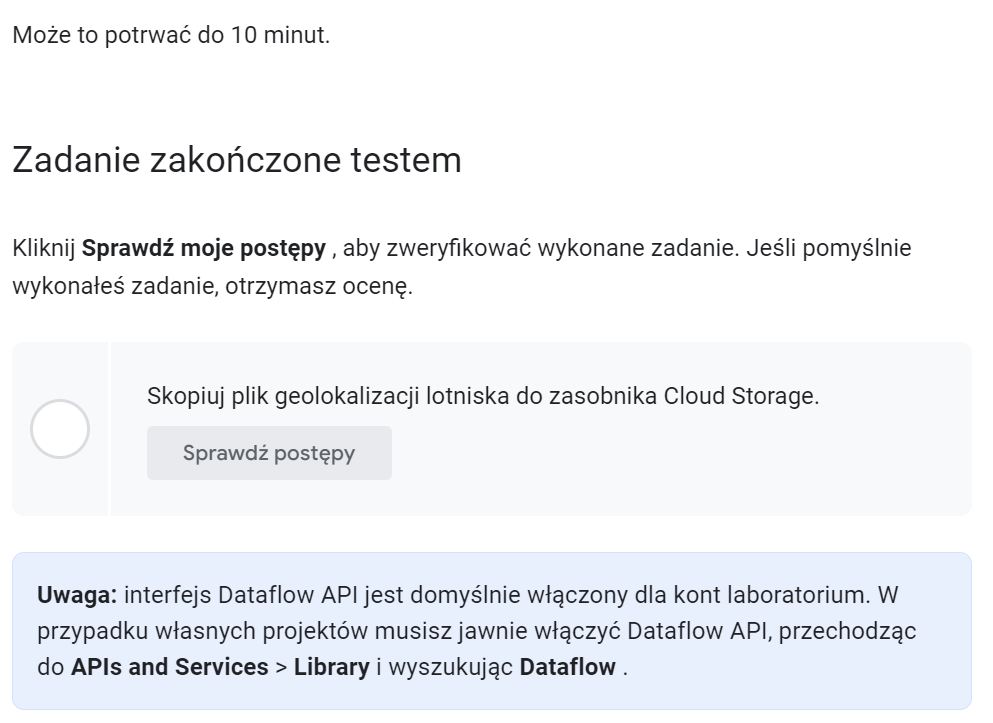

##Zadanie 3. Przetwórz dane za pomocą Dataflow

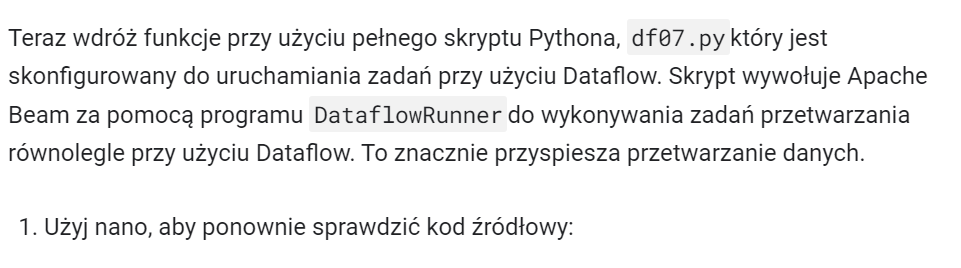

In [ ]:
nano df07.py

###`df07.py`

In [ ]:
# https://github.com/GoogleCloudPlatform/data-science-on-gcp/blob/main/04_streaming/transform/df07.py

#!/usr/bin/env python3

# Copyright 2016 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import apache_beam as beam
import logging
import csv
import json

DATETIME_FORMAT = '%Y-%m-%dT%H:%M:%S'


def addtimezone(lat, lon):
    try:
        import timezonefinder
        tf = timezonefinder.TimezoneFinder()
        lat = float(lat)
        lon = float(lon)
        return lat, lon, tf.timezone_at(lng=lon, lat=lat)
    except ValueError:
        return lat, lon, 'TIMEZONE'  # header


def as_utc(date, hhmm, tzone):
    """
    Returns date corrected for timezone, and the tzoffset
    """
    try:
        if len(hhmm) > 0 and tzone is not None:
            import datetime, pytz
            loc_tz = pytz.timezone(tzone)
            loc_dt = loc_tz.localize(datetime.datetime.strptime(date, '%Y-%m-%d'), is_dst=False)
            # can't just parse hhmm because the data contains 2400 and the like ...
            loc_dt += datetime.timedelta(hours=int(hhmm[:2]), minutes=int(hhmm[2:]))
            utc_dt = loc_dt.astimezone(pytz.utc)
            return utc_dt.strftime(DATETIME_FORMAT), loc_dt.utcoffset().total_seconds()
        else:
            return '', 0  # empty string corresponds to canceled flights
    except ValueError as e:
        logging.exception('{} {} {}'.format(date, hhmm, tzone))
        raise e


def add_24h_if_before(arrtime, deptime):
    import datetime
    if len(arrtime) > 0 and len(deptime) > 0 and arrtime < deptime:
        adt = datetime.datetime.strptime(arrtime, DATETIME_FORMAT)
        adt += datetime.timedelta(hours=24)
        return adt.strftime(DATETIME_FORMAT)
    else:
        return arrtime


def airport_timezone(airport_id, airport_timezones):
    if airport_id in airport_timezones:
        return airport_timezones[airport_id]
    else:
        return '37.41', '-92.35', u'America/Chicago'


def tz_correct(fields, airport_timezones):
    fields['FL_DATE'] = fields['FL_DATE'].strftime('%Y-%m-%d')  # convert to a string so JSON code works

    # convert all times to UTC
    dep_airport_id = fields["ORIGIN_AIRPORT_SEQ_ID"]
    arr_airport_id = fields["DEST_AIRPORT_SEQ_ID"]
    fields["DEP_AIRPORT_LAT"], fields["DEP_AIRPORT_LON"], dep_timezone = airport_timezone(dep_airport_id,
                                                                                          airport_timezones)
    fields["ARR_AIRPORT_LAT"], fields["ARR_AIRPORT_LON"], arr_timezone = airport_timezone(arr_airport_id,
                                                                                          airport_timezones)

    for f in ["CRS_DEP_TIME", "DEP_TIME", "WHEELS_OFF"]:
        fields[f], deptz = as_utc(fields["FL_DATE"], fields[f], dep_timezone)
    for f in ["WHEELS_ON", "CRS_ARR_TIME", "ARR_TIME"]:
        fields[f], arrtz = as_utc(fields["FL_DATE"], fields[f], arr_timezone)

    for f in ["WHEELS_OFF", "WHEELS_ON", "CRS_ARR_TIME", "ARR_TIME"]:
        fields[f] = add_24h_if_before(fields[f], fields["DEP_TIME"])

    fields["DEP_AIRPORT_TZOFFSET"] = deptz
    fields["ARR_AIRPORT_TZOFFSET"] = arrtz
    yield fields


def get_next_event(fields):
    if len(fields["DEP_TIME"]) > 0:
        event = dict(fields)  # copy
        event["EVENT_TYPE"] = "departed"
        event["EVENT_TIME"] = fields["DEP_TIME"]
        for f in ["TAXI_OUT", "WHEELS_OFF", "WHEELS_ON", "TAXI_IN", "ARR_TIME", "ARR_DELAY", "DISTANCE"]:
            event.pop(f, None)  # not knowable at departure time
        yield event
    if len(fields["WHEELS_OFF"]) > 0:
        event = dict(fields)  # copy
        event["EVENT_TYPE"] = "wheelsoff"
        event["EVENT_TIME"] = fields["WHEELS_OFF"]
        for f in ["WHEELS_ON", "TAXI_IN", "ARR_TIME", "ARR_DELAY", "DISTANCE"]:
            event.pop(f, None)  # not knowable at departure time
        yield event
    if len(fields["ARR_TIME"]) > 0:
        event = dict(fields)
        event["EVENT_TYPE"] = "arrived"
        event["EVENT_TIME"] = fields["ARR_TIME"]
        yield event


def create_event_row(fields):
    featdict = dict(fields)  # copy
    featdict['EVENT_DATA'] = json.dumps(fields)
    return featdict


def run(project, bucket, region):
    argv = [
        '--project={0}'.format(project),
        '--job_name=ch04timecorr',
        '--save_main_session',
        '--staging_location=gs://{0}/flights/staging/'.format(bucket),
        '--temp_location=gs://{0}/flights/temp/'.format(bucket),
        '--setup_file=./setup.py',
        '--autoscaling_algorithm=THROUGHPUT_BASED',
        '--max_num_workers=8',
        '--region={}'.format(region),
        '--runner=DataflowRunner'
    ]
    airports_filename = 'gs://{}/flights/airports/airports.csv.gz'.format(bucket)
    flights_output = 'gs://{}/flights/tzcorr/all_flights'.format(bucket)

    with beam.Pipeline(argv=argv) as pipeline:
        airports = (pipeline
                    | 'airports:read' >> beam.io.ReadFromText(airports_filename)
                    | 'airports:onlyUSA' >> beam.Filter(lambda line: "United States" in line)
                    | 'airports:fields' >> beam.Map(lambda line: next(csv.reader([line])))
                    | 'airports:tz' >> beam.Map(lambda fields: (fields[0], addtimezone(fields[21], fields[26])))
                    )

        flights = (pipeline
                   | 'flights:read' >> beam.io.ReadFromBigQuery(
                    query='SELECT * FROM dsongcp.flights', use_standard_sql=True)
                   | 'flights:tzcorr' >> beam.FlatMap(tz_correct, beam.pvalue.AsDict(airports))
                   )

        (flights
         | 'flights:tostring' >> beam.Map(lambda fields: json.dumps(fields))
         | 'flights:gcsout' >> beam.io.textio.WriteToText(flights_output)
         )

        flights_schema = ','.join([
            'FL_DATE:date,UNIQUE_CARRIER:string,ORIGIN_AIRPORT_SEQ_ID:string,ORIGIN:string',
            'DEST_AIRPORT_SEQ_ID:string,DEST:string,CRS_DEP_TIME:timestamp,DEP_TIME:timestamp',
            'DEP_DELAY:float,TAXI_OUT:float,WHEELS_OFF:timestamp,WHEELS_ON:timestamp,TAXI_IN:float',
            'CRS_ARR_TIME:timestamp,ARR_TIME:timestamp,ARR_DELAY:float,CANCELLED:boolean',
            'DIVERTED:boolean,DISTANCE:float',
            'DEP_AIRPORT_LAT:float,DEP_AIRPORT_LON:float,DEP_AIRPORT_TZOFFSET:float',
            'ARR_AIRPORT_LAT:float,ARR_AIRPORT_LON:float,ARR_AIRPORT_TZOFFSET:float'])
        flights | 'flights:bqout' >> beam.io.WriteToBigQuery(
            'dsongcp.flights_tzcorr', schema=flights_schema,
            write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE,
            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED
        )

        events = flights | beam.FlatMap(get_next_event)
        events_schema = ','.join([flights_schema, 'EVENT_TYPE:string,EVENT_TIME:timestamp,EVENT_DATA:string'])

        (events
         | 'events:totablerow' >> beam.Map(lambda fields: create_event_row(fields))
         | 'events:bqout' >> beam.io.WriteToBigQuery(
                    'dsongcp.flights_simevents', schema=events_schema,
                    write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE,
                    create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED
                )
         )


if __name__ == '__main__':
    import argparse

    parser = argparse.ArgumentParser(description='Run pipeline on the cloud')
    parser.add_argument('-p', '--project', help='Unique project ID', required=True)
    parser.add_argument('-b', '--bucket', help='Bucket where gs://BUCKET/flights/airports/airports.csv.gz exists',
                        required=True)
    parser.add_argument('-r', '--region',
                        help='Region in which to run the Dataflow job. Choose the same region as your bucket.',
                        required=True)

    args = vars(parser.parse_args())

    print("Correcting timestamps and writing to BigQuery dataset")

    run(project=args['project'], bucket=args['bucket'], region=args['region'])

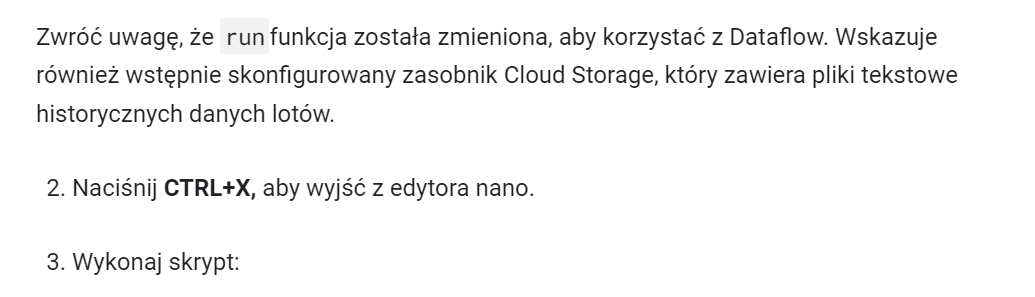

In [ ]:
./df07.py -p $PROJECT_ID -b $BUCKET -r us-west1

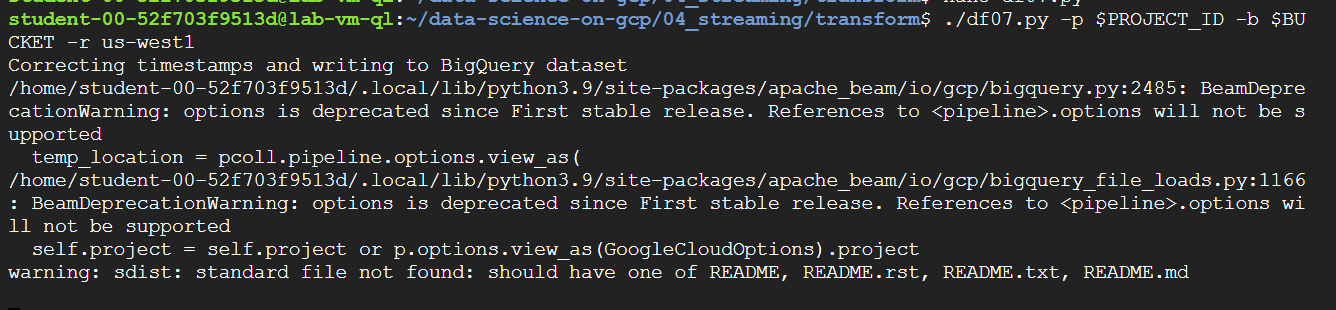

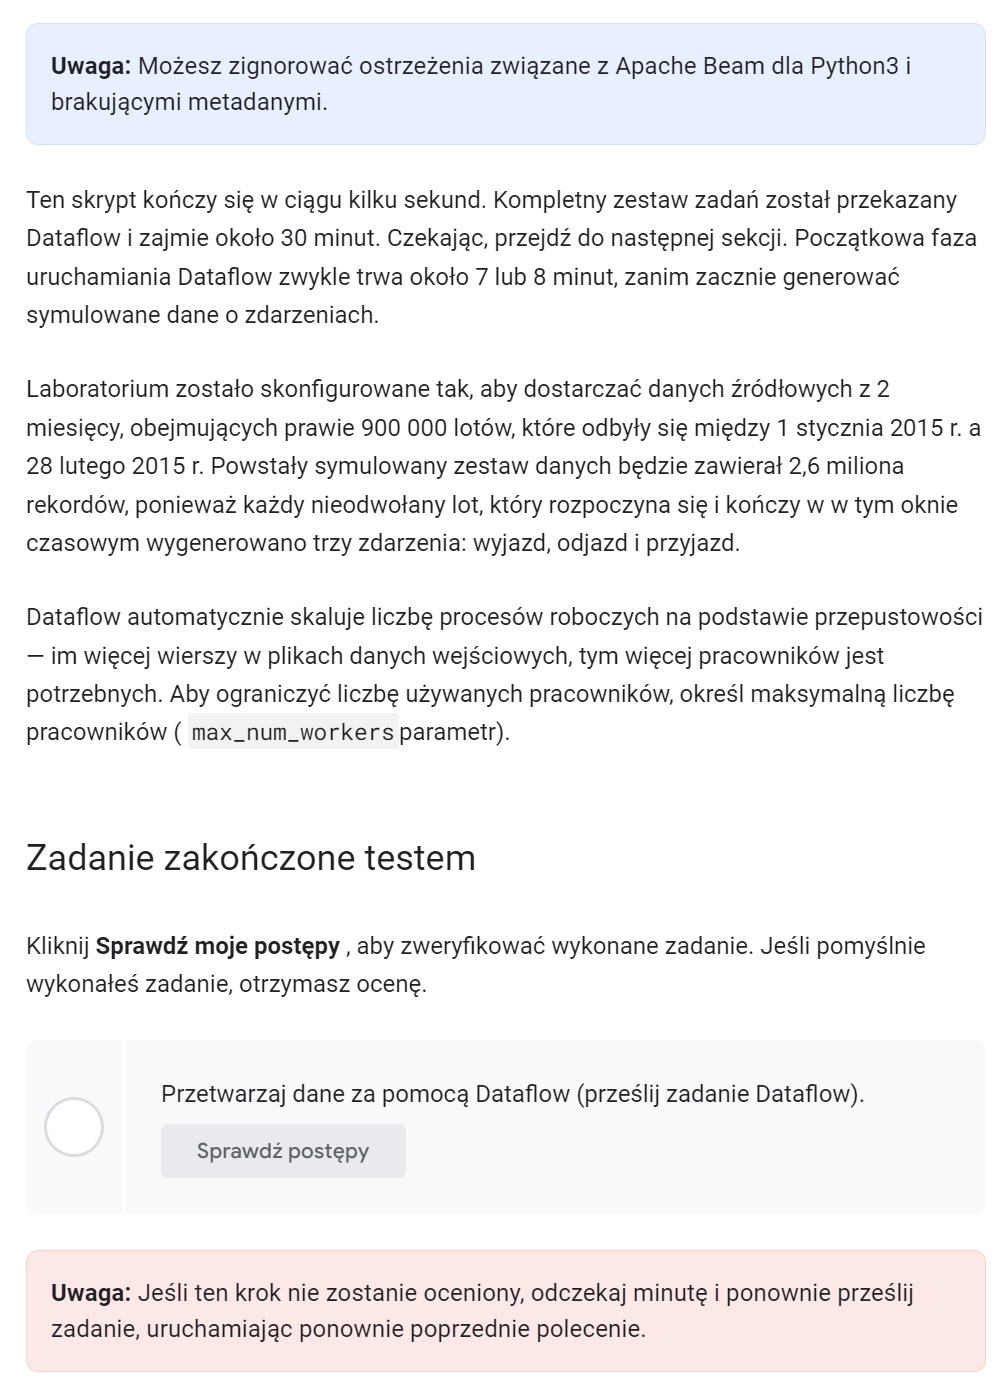

##Zadanie 4. Monitoruj zadanie Dataflow i sprawdzaj przetwarzane dane

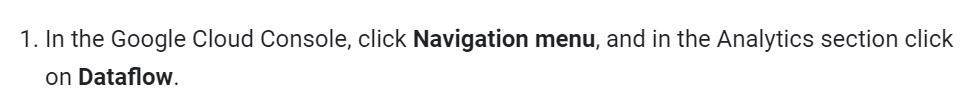

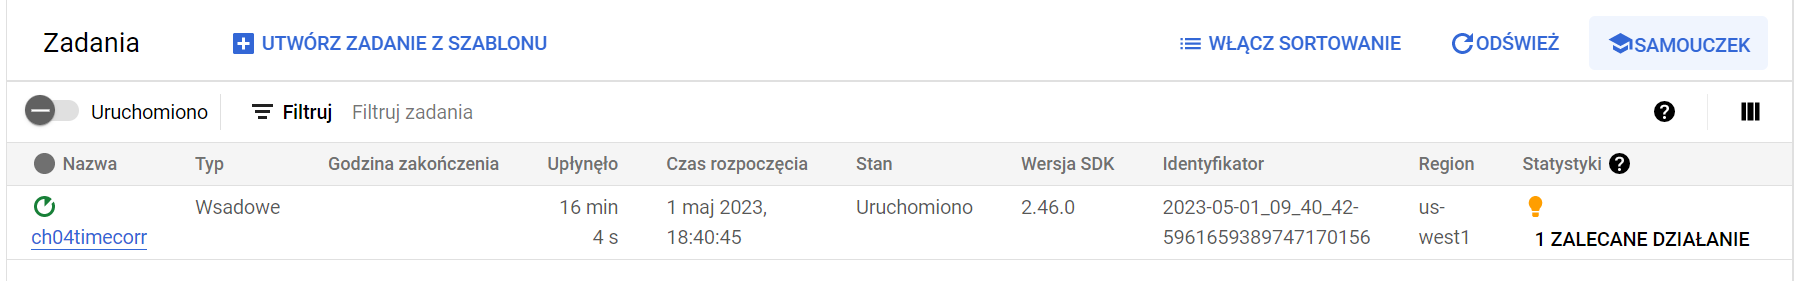

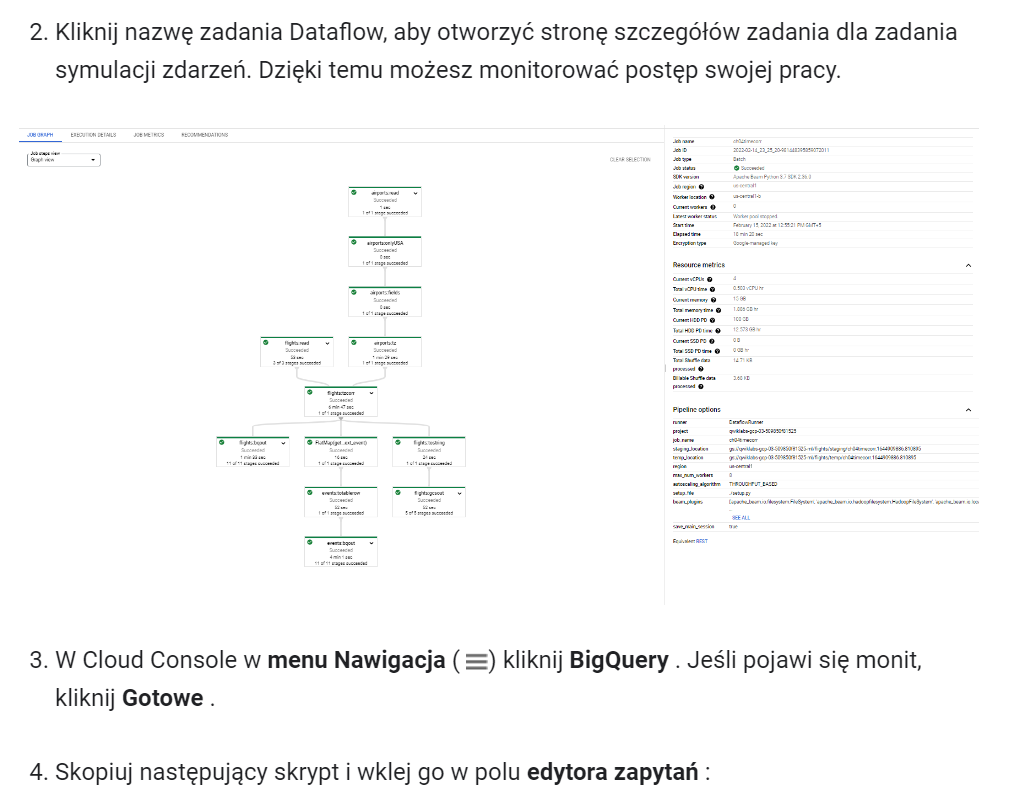

In [ ]:
%%bigquery

SELECT
  ORIGIN,
  DEP_TIME,
  DEST,
  ARR_TIME,
  ARR_DELAY,
  EVENT_TIME,
  EVENT_TYPE
FROM
  dsongcp.flights_simevents
WHERE
  (DEP_DELAY > 15 and ORIGIN = 'SEA') or
  (ARR_DELAY > 15 and DEST = 'SEA')
ORDER BY EVENT_TIME ASC
LIMIT
  5

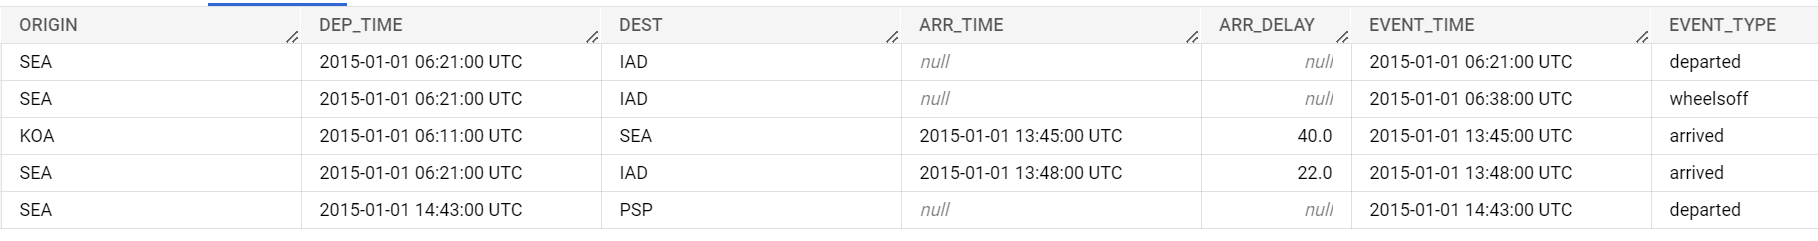

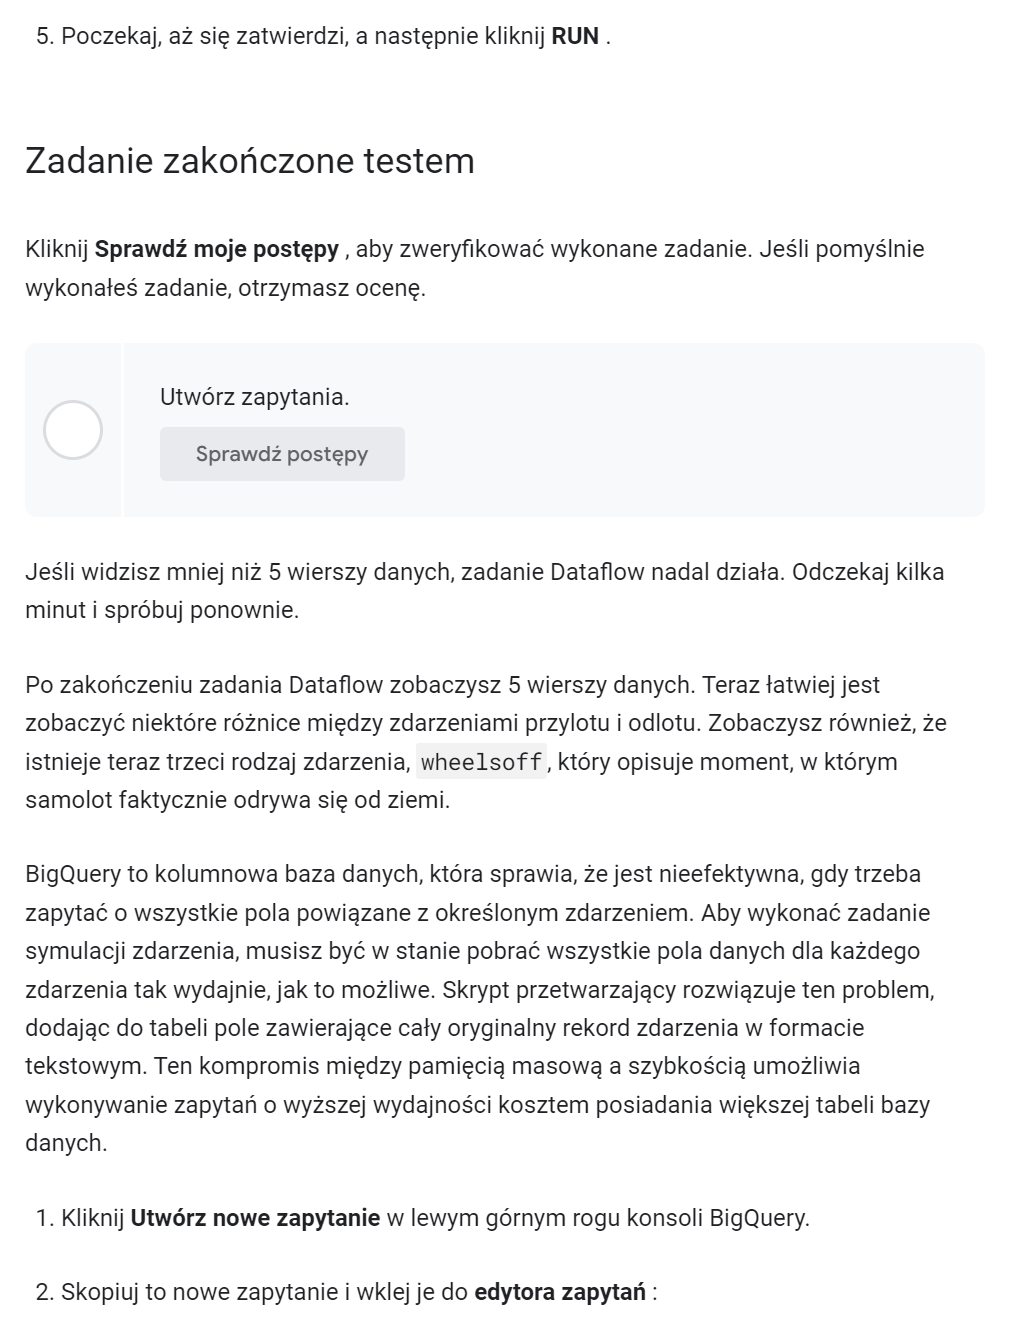

In [ ]:
%%bigquery

SELECT
  EVENT_TYPE,
  EVENT_TIME,
  EVENT_DATA
FROM
  `dsongcp.flights_simevents`
WHERE
  EVENT_TIME >= TIMESTAMP('2015-01-01 00:00:00 UTC')
  AND EVENT_TIME < TIMESTAMP('2015-01-03 00:00:00 UTC')
ORDER BY
  EVENT_TIME ASC
LIMIT
  2

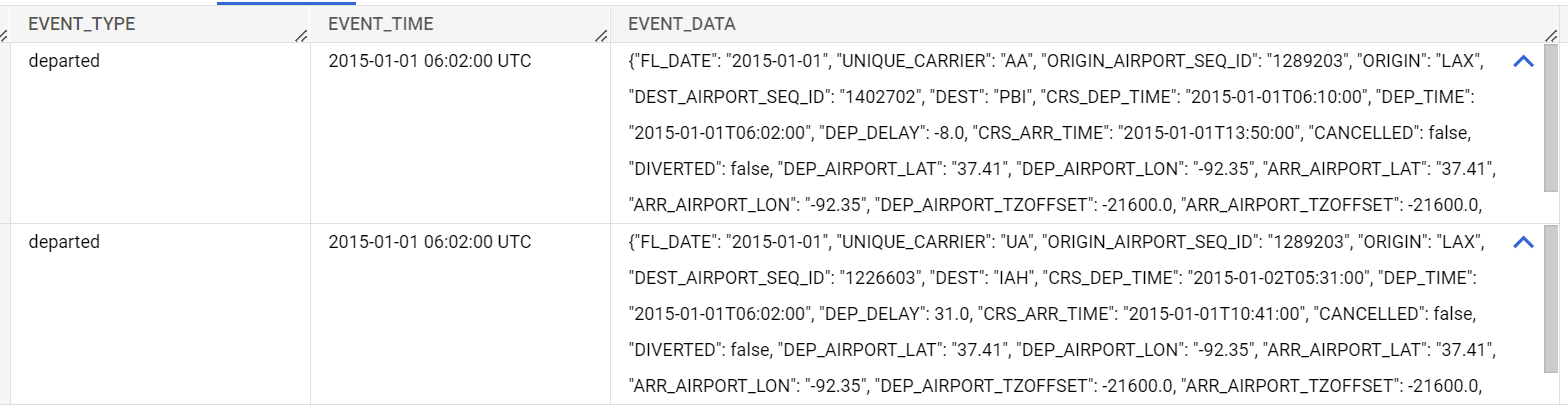

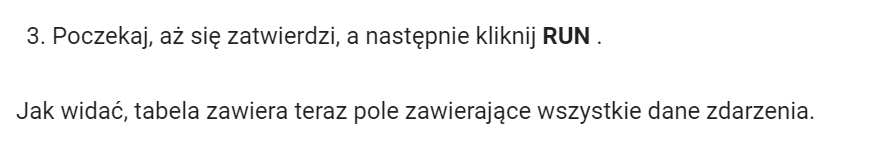

##Zadanie 5. Sprawdź swoje zrozumienie

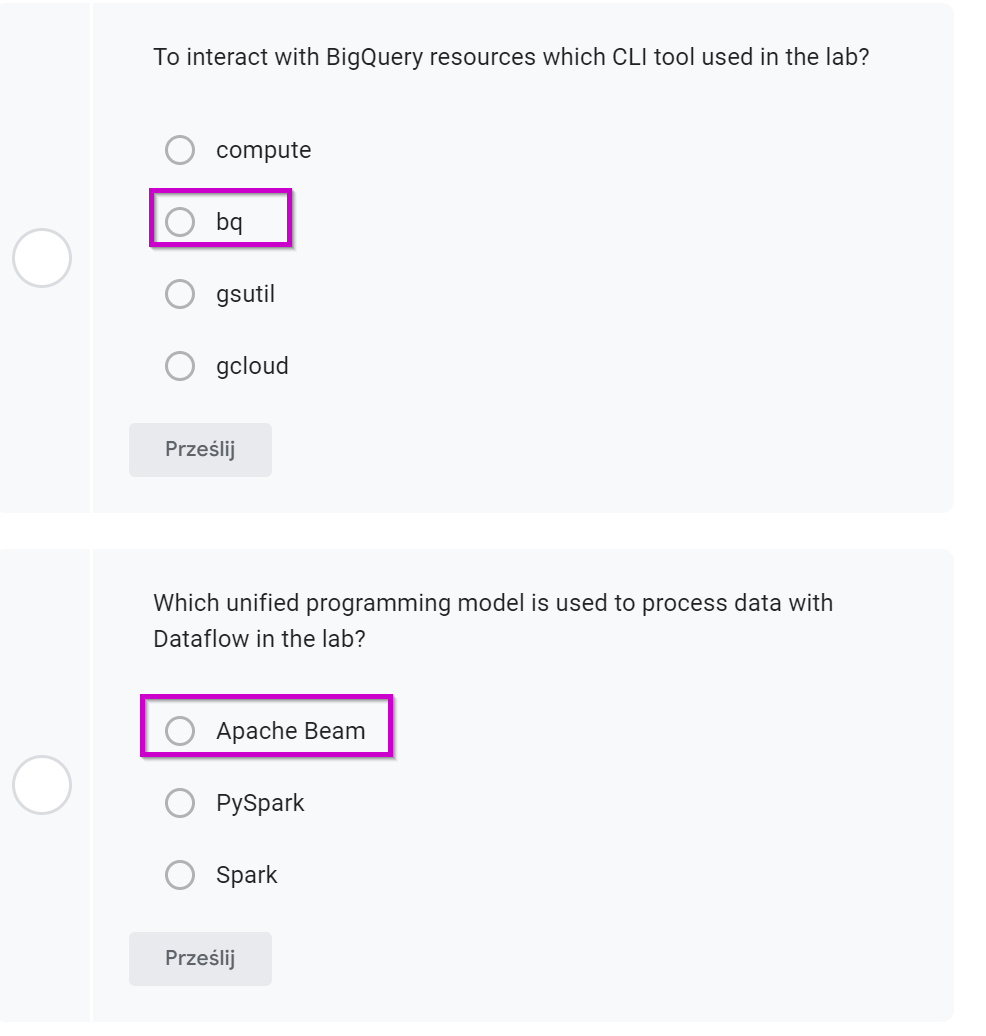